In [1]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
import sys
from nltk.corpus import stopwords
from string import punctuation
import os
from ufal.udpipe import Model, Pipeline
import re
import sklearn as sk
from sklearn.model_selection import train_test_split

## Предобработка текста
(P.S. на тестовом варианте небольшого текста рассказа О. Генри "Русские соболя".)

1. Предобработка текстовых данных
Функциональность RusVectōrēs позволяет пользователям делать запрос к моделям с одним конкретным словом или с несколькими словами. С помощью сервиса можно также анализировать отношения между бóльшим количеством слов.

Если взять уже готовую модель, а затем обрабатывать с её помощью тексты локальо на компьютере, то необходимо , чтобы данные, которые подаются на вход модели, были в том же формате, что и данные, на которых эта модель была натренирована. 


Предобработка текстов для тренировки моделей осуществлялась следующим образом:

лемматизация и удаление стоп-слов;
приведение лемм к нижнему регистру;
добавление частеречного тэга для каждого слова.

Особого внимания заслуживает последний пункт предобработки. Как можно видеть из таблицы с описанием моделей, частеречные тэги для слов в различных моделях принадлежат к разным тагсетам. Первые модели использовали тагсет Mystem, затем перешли на Universal POS tags. В моделях на базе fastText частеречные тэги не используются вовсе.

Давайте попробуем воссоздать процесс предобработки текста на примере рассказа О. Генри "Русские соболя". Для предобработки мы предлагаем использовать UDPipe, чтобы сразу получить частеречную разметку в виде Universal POS-tags.


Чтобы загружать файлы, можно использовать реализацию wget в виде питоновской библиотеки:

pip install wget

In [2]:
import wget

In [3]:
# Необходимо скачать модуль для предобработки текста(раставления_тегов_честей_речи)
# Делается только первый раз, далее всё загружаем из папки проекта
# udpipe_url = 'https://rusvectores.org/static/models/udpipe_syntagrus.model'
# text_url = 'https://rusvectores.org/static/henry_sobolya.txt'

# modelfile = wget.download(udpipe_url)
# textfile = wget.download(text_url)


In [4]:
# Проверяем наличие файлов в нашей папке проекта True-есть, False-отсутствуют

print(os.path.isfile('udpipe_syntagrus.model'))
print(os.path.isfile('henry_sobolya.txt'))

True
True


In [12]:
modelfile = 'udpipe_syntagrus.model'
textfile = 'henry_sobolya.txt'

Перед лемматизацией и тэггингом, модели были очищены от пунктуации и возможных ошибок при помощи фильтров . Вспомогательные функции для очистки текста в скрипте для препроцессинга. Две функции clean_token и clean_lemma для очистки от знаков препинания и различных типографических артефактов.

In [13]:
def num_replace(word):
    newtoken = 'x' * len(word)
    return newtoken


def clean_token(token, misc):
    out_token = token.strip().replace(' ', '')
    if token == 'Файл' and 'SpaceAfter=No' in misc:
        return None
    return out_token


def clean_lemma(lemma, pos):
    out_lemma = lemma.strip().replace(' ', '').replace('_', '').lower()
    if '|' in out_lemma or out_lemma.endswith('.jpg') or out_lemma.endswith('.png'):
        return None
    if pos != 'PUNCT':
        if out_lemma.startswith('«') or out_lemma.startswith('»'):
            out_lemma = ''.join(out_lemma[1:])
        if out_lemma.endswith('«') or out_lemma.endswith('»'):
            out_lemma = ''.join(out_lemma[:-1])
        if out_lemma.endswith('!') or out_lemma.endswith('?') or out_lemma.endswith(',') \
                or out_lemma.endswith('.'):
            out_lemma = ''.join(out_lemma[:-1])
    return out_lemma

Приступим к собственно предобработке текста. Попробуем лемматизировать текст и добавить частеречные тэги при помощи этой функции:

Эту функцию можно также изменить под конкретную задачу. Например, если частеречные тэги не нужны, в функции ниже выставим keep_pos=False. Если необходимо сохранить знаки пунктуации, можно выставить keep_punct=True

In [15]:
def process(pipeline, text='Строка', keep_pos=True, keep_punct=False):
    entities = {'PROPN'}
    named = False  # переменная для запоминания того, что нам встретилось имя собственное
    memory = []
    mem_case = None
    mem_number = None
    tagged_propn = []

    # обрабатываем текст, получаем результат в формате conllu:
    processed = pipeline.process(text)

    # пропускаем строки со служебной информацией:
    content = [l for l in processed.split('\n') if not l.startswith('#')]

    # извлекаем из обработанного текста леммы, тэги и морфологические характеристики
    tagged = [w.split('\t') for w in content if w]
    
    russian_stopwords = stopwords.words("russian")
    
    for t in tagged:
        if len(t) != 10: # если список короткий — строчка не содержит разбора, пропускаем
            continue
        (word_id,token,lemma,pos,xpos,feats,head,deprel,deps,misc) = t
        token = clean_token(token, misc)
        lemma = clean_lemma(lemma, pos)
        if token in  russian_stopwords: # если стоп-слово — пропускаем, не будет использовано
            continue
        if not lemma or not token: # если слово пустое — пропускаем
            continue
        if pos in entities: # здесь отдельно обрабатываем имена собственные — они требуют особого обращения
            if '|' not in feats:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            morph = {el.split('=')[0]: el.split('=')[1] for el in feats.split('|')}
            if 'Case' not in morph or 'Number' not in morph:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            if not named:
                named = True
                mem_case = morph['Case']
                mem_number = morph['Number']
            if morph['Case'] == mem_case and morph['Number'] == mem_number:
                memory.append(lemma)
                if 'SpacesAfter=\\n' in misc or 'SpacesAfter=\s\\n' in misc:
                    named = False
                    past_lemma = '::'.join(memory)
                    memory = []
                    tagged_propn.append(past_lemma + '_PROPN ')
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN ')
                tagged_propn.append('%s_%s' % (lemma, pos))
        else:
            if not named:
                if pos == 'NUM' and token.isdigit():  # Заменяем числа на xxxxx той же длины
                    lemma = num_replace(token)
                tagged_propn.append('%s_%s' % (lemma, pos))
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN ')
                tagged_propn.append('%s_%s' % (lemma, pos))
            
    if not keep_punct: # обрабатываем случай, когда пользователь попросил не сохранять пунктуацию (по умолчанию она сохраняется)
        tagged_propn = [word for word in tagged_propn if word.split('_')[1] != 'PUNCT']
    if not keep_pos:
        tagged_propn = [word.split('_')[0] for word in tagged_propn]
    return tagged_propn

Загружаем модель UDPipe, читаем текстовый файл и обрабатываем его при помощи функции. В файле должен содержаться необработанный текст (одно предложение на строку или один абзац на строку). На выход мы получаем последовательность разделенных пробелами лемм с частями речи («зеленый_NOUN трамвай_NOUN»).

In [16]:
modelfile='udpipe_syntagrus.model'
model = Model.load(modelfile)
process_pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')

In [17]:
def tag_ud(text,process_pipeline):
    #udpipe_model_url = 'https://rusvectores.org/static/models/udpipe_syntagrus.model'
    #udpipe_filename = udpipe_model_url.split('/')[-1]

    #if not os.path.isfile(model):
        #print('UDPipe model not found. Downloading...', file=sys.stderr)
        #wget.download(udpipe_model_url)

    #print('\nLoading the model...', file=sys.stderr)
    #model = Model.load(modelfile)
    #process_pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')

    #print('Processing input...', file=sys.stderr)
    lines = text.split('\n')
    tagged = []
    for line in lines:
        # line = unify_sym(line.strip()) # здесь могла бы быть ваша функция очистки текста
        output = process(process_pipeline, text=line)
        tagged_line = ' '.join(output)
        tagged.append(tagged_line)
    #print('Текст обработан')
    return '\n'.join(tagged)

In [18]:
text = open(textfile, 'r', encoding='utf-8').read()

In [19]:
%%time
processed_text = tag_ud(text, process_pipeline)
print(processed_text[:350])
with open('my_text.txt', 'w', encoding='utf-8') as out:
    out.write(processed_text)

русский_PROPN  соболь_NOUN о::генри_PROPN 
когда_SCONJ синий_ADJ ночь_NOUN глаз_NOUN молли_VERB мак-кивер_PROPN  класть_VERB малыш::брэди_PROPN  оба_NUM лопатка_NOUN вынужденный_ADJ покидать_VERB ряд_NOUN банда_NOUN дымовый_ADJ труба_NOUN таков_ADJ власть_NOUN нежный_ADJ укор_NOUN подружка_NOUN упрямый_ADJ пристрастие_NOUN порядочность_NOUN если_SC
CPU times: user 3.12 s, sys: 12.9 ms, total: 3.13 s
Wall time: 3.19 s


## Предобработка текстовых новостей 
(Датасет Kggle)

Загружаем данные (https://www.kaggle.com/yutkin/corpus-of-russian-news-articles-from-lenta)

Корпус новостей с Lenta.Ru

Размер: 2 Гб
Количество новостей: 800K+
Период: Сентябрь 1999 - декабрь 2019

In [7]:
%%time
df = pd.read_csv('lenta-ru-news.csv')
df = df.dropna()

<decorator-gen-54>:2: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 26.4 s, sys: 2.43 s, total: 28.9 s
Wall time: 31.2 s


In [8]:
df.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712654 entries, 0 to 739175
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     712654 non-null  object
 1   title   712654 non-null  object
 2   text    712654 non-null  object
 3   topic   712654 non-null  object
 4   tags    712654 non-null  object
 5   date    712654 non-null  object
dtypes: object(6)
memory usage: 38.1+ MB


In [10]:
df.describe()

,url,title,text,topic,tags,date
count,712654,712654,712654,712654,712654,712654
unique,712643,710040,711725,23,88,7029
top,https://lenta.ru/news/1999/11/18/berezovsky/,В Москве объявлено штормовое предупреждение,"РИА ""Новости""",Россия,Все,2008/12/08
freq,2,21,291,155004,453581,260


In [23]:
"""
# Преобработка текста производилась частями, для этого использовался данный скрипт
%%time
for i in range(600000,len(df)):
    text = df.iloc[i,2]
    processed_text = tag_ud(text, process_pipeline)
    df.iloc[i,2]=processed_text
    if i==1000:
        print('1000')
    if i==10000:
        print('10000')
    if i==50000:
        print('50000')
    if i==100000:
        print('100000')
    if i==300000:
        print('300000')
    if i==600000:
        print('600000')
"""    

1000
10000
50000
100000
300000
600000
Wall time: 7h 5min 59s


In [24]:
'''
#Сохраняем частями

df.to_csv('ch_5.csv')
'''

## Загружаем таблицу с предобработанными новостями

In [5]:
%%time
# Загружаем из базы таблицу с обработанными новостями
df = pd.read_csv('good_text_teg.csv')

CPU times: user 29 s, sys: 2.54 s, total: 31.5 s
Wall time: 34.8 s


In [6]:
df.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,бой_NOUN сопоцкин_PROPN друскеник_PROPN закан...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,министерство_PROPN народный_ADJ просвещение_N...,Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,штабс-капитан_NOUN п::н::нестеров_PROPN день_...,Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,фотограф-корреспондент_NOUN daily_PROPN mirror...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,лицо_NOUN приезжать_VERB варшава_NOUN люблин_P...,Библиотека,Первая мировая,1914/09/18


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712654 entries, 0 to 712653
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     712654 non-null  object
 1   title   712654 non-null  object
 2   text    712654 non-null  object
 3   topic   712654 non-null  object
 4   tags    712654 non-null  object
 5   date    712654 non-null  object
dtypes: object(6)
memory usage: 32.6+ MB


In [8]:
df.describe()

,url,title,text,topic,tags,date
count,712654,712654,712654,712654,712654,712654
unique,712643,710040,711658,23,88,7029
top,https://lenta.ru/news/2001/06/28/milosevic/,В Москве объявлено штормовое предупреждение,риа_PROPN новость_PROPN,Россия,Все,2008/12/08
freq,2,21,291,155004,453581,260


In [9]:
df.topic.unique()

array(['Библиотека', 'Россия', 'Мир', 'Экономика', 'Интернет и СМИ',
       'Спорт', 'Культура', 'Из жизни', 'Наука и техника', 'Бывший СССР',
       'Дом', 'Сочи', 'ЧМ-2014', 'Путешествия', 'Силовые структуры',
       'Ценности', 'Легпром', 'Бизнес', 'МедНовости', 'Оружие',
       '69-я параллель', 'Культпросвет ', 'Крым'], dtype=object)

In [10]:
# Распределение новостей по топикам
df.groupby(['topic']).size()

topic
69-я параллель         1268
Библиотека               65
Бизнес                 7375
Бывший СССР           51370
Дом                   21734
Из жизни              27513
Интернет и СМИ        44421
Крым                    666
Культпросвет            340
Культура              53530
Легпром                 114
МедНовости                1
Мир                  136620
Наука и техника       53136
Оружие                    3
Путешествия            6370
Россия               155004
Силовые структуры     11223
Сочи                      1
Спорт                 57894
Ценности               7581
ЧМ-2014                   2
Экономика             76423
dtype: int64

In [11]:
# Выведем те классы в которых содержится менее 1000 новостей 
m = df.groupby(['topic']).size()
print(m[m<1000])

topic
Библиотека        65
Крым             666
Культпросвет     340
Легпром          114
МедНовости         1
Оружие             3
Сочи               1
ЧМ-2014            2
dtype: int64


In [12]:
# Присоединим маленькие классы к большим
df.loc[(df['topic'] == 'Библиотека'), 'topic'] = 'Интернет и СМИ'
df.loc[(df['topic'] == 'Крым'), 'topic'] = 'Россия'
df.loc[(df['topic'] == 'Культпросвет '), 'topic'] = 'Культура'
df.loc[(df['topic'] == 'Легпром'), 'topic'] = 'Бизнес'
df.loc[(df['topic'] == 'МедНовости'), 'topic'] = 'Из жизни'
df.loc[(df['topic'] == 'Оружие'), 'topic'] = 'Силовые структуры'
df.loc[(df['topic'] == 'Сочи'), 'topic'] = 'Россия'
df.loc[(df['topic'] == 'ЧМ-2014'), 'topic'] = 'Спорт'

In [13]:
# Получаем, распределение новостей по топикам
df.groupby(['topic']).size()

topic
69-я параллель         1268
Бизнес                 7489
Бывший СССР           51370
Дом                   21734
Из жизни              27514
Интернет и СМИ        44486
Культура              53870
Мир                  136620
Наука и техника       53136
Путешествия            6370
Россия               155671
Силовые структуры     11226
Спорт                 57896
Ценности               7581
Экономика             76423
dtype: int64

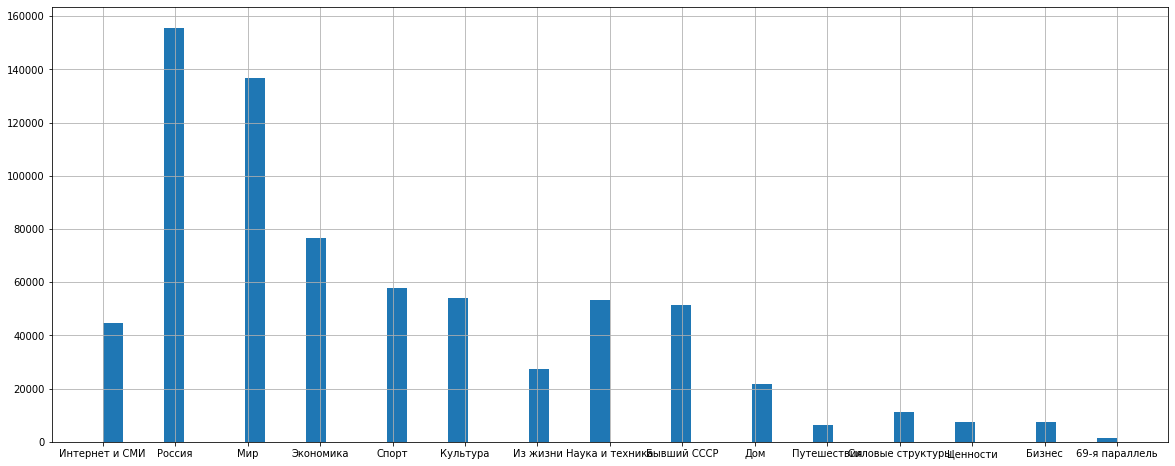

In [14]:
h = df.topic.hist(figsize = (20,8), bins = 50)

In [15]:
#Возьмем 10% реперзентативной выборки для удобной работы. 
ta, small_df = train_test_split(df, test_size=0.1, random_state=42)

In [16]:
# Распределение новостей по топикам для выборки
small_df.groupby(['topic']).size()

topic
69-я параллель         113
Бизнес                 753
Бывший СССР           5170
Дом                   2153
Из жизни              2759
Интернет и СМИ        4468
Культура              5405
Мир                  13718
Наука и техника       5250
Путешествия            645
Россия               15500
Силовые структуры     1085
Спорт                 5894
Ценности               745
Экономика             7608
dtype: int64

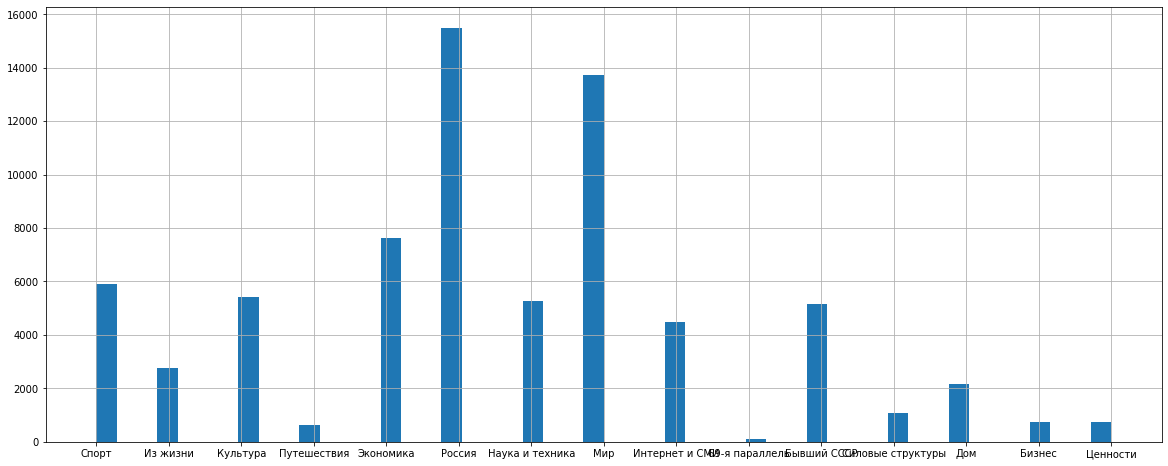

In [17]:
h = small_df.topic.hist(figsize = (20,8), bins = 50)

## Работа с моделью w2v, преобразование текстовых новостей в средний вектор

In [18]:
import zipfile

In [19]:
# Необходимо скачать обученный корпус для представления слов в виде векторов,
# Делается только первый раз, далее всё загружаем из папки проекта

model_url = 'http://vectors.nlpl.eu/repository/20/184.zip'
#m = wget.download(model_url)

In [20]:
# Проверяем наличие файлa в нашей папке проекта True-есть, False-отсутствуют

print(os.path.isfile('184.zip'))

True


In [21]:
# Корпус обученный на рускоязычных новостях

# model_file = '184.zip'

In [22]:
model_file = model_url.split('/')[-1]
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

2020-11-29 13:54:11,796 : INFO : loading projection weights from <zipfile.ZipExtFile name='model.bin' mode='r' compress_type=deflate>
2020-11-29 13:54:18,488 : INFO : loaded (249318, 300) matrix from <zipfile.ZipExtFile [closed]>


In [23]:
wv = model

In [24]:
#Разделим нашу таблицу на обучение и тест
train_data, test_data = train_test_split(small_df, test_size=0.1, random_state=42)

In [25]:
def word_averaging(wv, words):
    ''' Функция, Из "текста новости в вектор" '''
    words=words.split( )
    mean = []
    for word in words: 
        if isinstance(word, np.ndarray): # isinstance(a,type) функция возвращает True, если переменная a типа type
            mean.append(word) # Добавить в word в конец переменой mean
        elif word in wv.vocab: # wv.vocab-это словарь обученной модели w2v , где каждому слово_teg ставится в соответствии вектор 
            mean.append(wv.word_vec(word, use_norm = False))

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words) 
        # FIXME: remove these examples in pre-processing
        #return np.zeros(wv.layer1_size,)
        return np.zeros(wv.vector_size,) # Одномерный нулевой массив, размерность которого - размерность вектора модели W2V 
    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32) # Берём средний вектор и затем нормализуем и приводим к типу флот32
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list])

In [26]:
%%time
X_train_word_average = word_averaging_list(wv,train_data.text)
X_test_word_average = word_averaging_list(wv,test_data.text)

2020-11-29 13:54:33,801 : WARNING : cannot compute similarity with no input ['news24.com_X']
2020-11-29 13:54:37,698 : WARNING : cannot compute similarity with no input ['defensetech_PROPN']
2020-11-29 13:54:53,779 : WARNING : cannot compute similarity with no input ['.redirectto_PROPN']
2020-11-29 13:54:53,859 : WARNING : cannot compute similarity with no input ['dw-world_PROPN']


CPU times: user 36.8 s, sys: 143 ms, total: 36.9 s
Wall time: 37.1 s


## 1. Метод KNN

Для классификации каждого из объектов тестовой выборки необходимо последовательно выполнить следующие операции:

 1) Вычислить расстояние до каждого из объектов обучающей выборки
 
 2) Отобрать $k$ объектов обучающей выборки, расстояние до которых минимально
 
 3) Класс классифицируемого объекта — это класс, наиболее часто встречающийся среди $k$ ближайших соседей

Качество классификации методом ближайших соседей зависит от нескольких параметров:

1) число соседей

2) метрика расстояния между объектами (часто используются метрика Хэмминга, евклидово расстояние, косинусное расстояние и расстояние Минковского). Отметим, что при использовании большинства метрик значения признаков надо масштабировать. Условно говоря, чтобы признак "Зарплата" с диапазоном значений до 100 тысяч не вносил больший вклад в расстояние, чем "Возраст" со значениями до 100.

3) веса соседей (соседи тестового примера могут входить с разными весами, например, чем дальше пример, тем с меньшим коэффициентом учитывается его "голос")

###### Выбор параметров модели и кросс-валидация

Главная задача обучаемых алгоритмов – их способность обобщаться, то есть хорошо работать на новых данных. Поскольку, на новых данных мы сразу не можем проверить качество построенной модели (нам ведь надо для них сделать прогноз, то есть истинных значений целевого признака мы для них не знаем), то надо пожертвовать небольшой порцией данных, чтоб на ней проверить качество модели.

Чаще всего это делается одним из 2 способов:

1) отложенная выборка (held-out/hold-out set). При таком подходе мы оставляем какую-то долю обучающей выборки (как правило от 20% до 40%), обучаем модель на остальных данных (60-80% исходной выборки) и считаем некоторую метрику качества модели (например, самое простое – долю правильных ответов в задаче классификации) на отложенной выборке.

2) кросс-валидация (cross-validation, на русский еще переводят как скользящий или перекрестный контроль). Тут самый частый случай – K-fold кросс-валидация

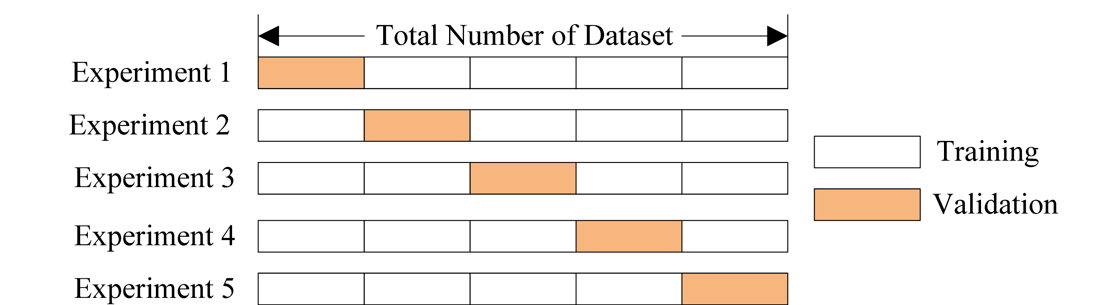

Тут модель обучается K раз на разных $(K-1)$ подвыборках исходной выборки (белый цвет), а проверяется на одной подвыборке (каждый раз на разной, оранжевый цвет). Получаются $K$ оценок качества модели, которые обычно усредняются, выдавая среднюю оценку качества классификации/регресии на кросс-валидации.

Кросс-валидация дает лучшую по сравнению отложенной выборкой оценку качества модели на новых данных. Но кросс-валидация вычислительно дорогостоящая, если данных много.

Кросс-валидация – очень важная техника в машинном обучении (применяемая также в статистике и эконометрике), с ее помощью выбираются гиперпараметры моделей, сравниваются модели между собой, оценивается полезность новых признаков в задаче и т.д.

#### 1.1 Выбор оптимальных параметров

Т.к. Для поиска близости векторов наилучшим образом подойдёт "косиново расстояние" 

In [25]:
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics 

In [44]:
knn_naive_dv = KNeighborsClassifier(n_jobs=-1, algorithm='brute', metric='cosine')

Т.к. Найдём оптимальное число ближайших соседей для выборки наших данных с помощью GridSearchCV()

In [113]:
from sklearn.model_selection import GridSearchCV

In [114]:
# Найдём наилучшее значение Ф-меры модели, при различных k = [5, 10, 15, 20, 30, 40, 50]
knn_params = {'n_neighbors': [5, 10, 15, 20, 30, 40, 50]}

In [115]:
%%time
knn_grid = GridSearchCV(knn_naive_dv, knn_params, scoring='f1_micro', n_jobs=-1)

Wall time: 0 ns


In [116]:
%%time
knn_grid.fit(X_train_word_average, train_data.topic)

Wall time: 43min 57s


GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30,
                                            metric='cosine', metric_params=None,
                                            n_jobs=-1, n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 15, 20, 30, 40, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_micro', verbose=0)

In [117]:
# Вывод наилучшего значения Ф-меры и значения числа соседей для данной модели
knn_grid.best_score_, knn_grid.best_params_

(0.7829401357524879, {'n_neighbors': 15})

In [128]:
# Построение сетки значений Ф-меры для различного числа ближайших соседей 
means = knn_grid.cv_results_['mean_test_score']
for mean, params in zip(means, knn_grid.cv_results_['params']):
    print("%0.4f for %r" % (mean, params))

0.7753 for {'n_neighbors': 5}
0.7826 for {'n_neighbors': 10}
0.7829 for {'n_neighbors': 15}
0.7818 for {'n_neighbors': 20}
0.7788 for {'n_neighbors': 30}
0.7765 for {'n_neighbors': 40}
0.7738 for {'n_neighbors': 50}


###### Вывод:

Наибольшее значение Ф-мера принимает при числе соседий от 10 до 20

In [163]:
knn_naive_dv = KNeighborsClassifier(n_jobs=-1, metric='cosine')

In [164]:
# Найдём наилучшее значение Ф-меры модели, при различных k = [12, 13, 14, 15, 16, 17, 18]
knn_params = {'n_neighbors': [12, 13, 14, 15, 16, 17, 18]}

In [165]:
%%time
knn_grid = GridSearchCV(knn_naive_dv, knn_params, scoring='f1_micro', n_jobs=-1)

Wall time: 0 ns


In [166]:
%%time
knn_grid.fit(X_train_word_average, train_data.topic)

Wall time: 43min 13s


GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='cosine', metric_params=None,
                                            n_jobs=-1, n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [12, 13, 14, 15, 16, 17, 18]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_micro', verbose=0)

In [167]:
# Вывод наилучшего значения Ф-меры и значения числа соседей для данной модели
knn_grid.best_score_, knn_grid.best_params_

(0.7832207669991015, {'n_neighbors': 16})

In [168]:
# Построение сетки значений Ф-меры для различного числа ближайших соседей 
means = knn_grid.cv_results_['mean_test_score']
for mean, params in zip(means, knn_grid.cv_results_['params']):
    print("%0.4f for %r" % (mean, params))

0.7824 for {'n_neighbors': 12}
0.7825 for {'n_neighbors': 13}
0.7829 for {'n_neighbors': 14}
0.7829 for {'n_neighbors': 15}
0.7832 for {'n_neighbors': 16}
0.7825 for {'n_neighbors': 17}
0.7827 for {'n_neighbors': 18}


###### Вывод:

Наибольшее значение Ф-мера принимает при 16 числе соседий. Оптимальные параметры числа соседей подобраны.

#### Для всего датасета df

In [178]:
#Разделим нашу таблицу на обучение и тест 
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)

In [179]:
%%time
X_train_word_average = word_averaging_list(wv,train_data.text)
X_test_word_average = word_averaging_list(wv,test_data.text)

2020-11-09 02:07:20,316 : WARNING : cannot compute similarity with no input ['.redirectto_PROPN']
2020-11-09 02:07:55,423 : WARNING : cannot compute similarity with no input ['жозефина-шарлотт_NOUN']
2020-11-09 02:07:58,259 : WARNING : cannot compute similarity with no input ['.redirectto_PROPN']
2020-11-09 02:08:59,242 : WARNING : cannot compute similarity with no input ['вттво_ADJ', '-омск_PROPN', 'xxxx_NUM']
2020-11-09 02:09:45,710 : WARNING : cannot compute similarity with no input ['каден_ADJ']
2020-11-09 02:10:35,796 : WARNING : cannot compute similarity with no input ['.redirectto_PROPN']
2020-11-09 02:10:38,140 : WARNING : cannot compute similarity with no input ['тунгуска-м1_NUM']
2020-11-09 02:11:13,732 : WARNING : cannot compute similarity with no input ['scotsman.com_NOUN']
2020-11-09 02:12:02,100 : WARNING : cannot compute similarity with no input ['кабар_NOUN']
2020-11-09 02:12:49,005 : WARNING : cannot compute similarity with no input ['хорайзон_PART']
2020-11-09 02:13:3

2020-11-09 02:22:11,139 : WARNING : cannot compute similarity with no input ['news24.com_X']
2020-11-09 02:22:14,992 : WARNING : cannot compute similarity with no input ['naturwissenschaften_PROPN']
2020-11-09 02:22:30,630 : WARNING : cannot compute similarity with no input ['erna_PROPN', 'retk_PROPN', 'xxxx_NUM']
2020-11-09 02:22:36,714 : WARNING : cannot compute similarity with no input ['venezuelanalysis.com_X']
2020-11-09 02:22:37,569 : WARNING : cannot compute similarity with no input ['.redirectto_PROPN']
2020-11-09 02:22:39,037 : WARNING : cannot compute similarity with no input ['drudgereport_PROPN']
2020-11-09 02:22:44,073 : WARNING : cannot compute similarity with no input ['.redirectto_PROPN']
2020-11-09 02:22:46,706 : WARNING : cannot compute similarity with no input ['myxococcus_PROPN', 'xanthus_X']
2020-11-09 02:22:50,060 : WARNING : cannot compute similarity with no input ['thechamplainchannel.com_PROPN']
2020-11-09 02:22:52,488 : WARNING : cannot compute similarity with

Wall time: 25min 58s


In [180]:
%%time
knn_naive_dv = KNeighborsClassifier(n_neighbors=16, n_jobs=-1, algorithm='brute', metric='cosine' )
knn_naive_dv.fit(X_train_word_average, train_data.topic)

Wall time: 6.39 s
Compiler : 169 ms
Parser   : 298 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
                     weights='uniform')

In [181]:
%%time
predicted = knn_naive_dv.predict(X_test_word_average)

Wall time: 1h 34min 2s
Parser   : 374 ms


In [182]:
import sklearn.metrics

In [28]:
sklearn.metrics.f1_score(test_data.topic, predicted,average ='micro') # 16

0.8200965397244128

## 2. SVM

In [27]:
from sklearn.svm import SVC 
import sklearn.metrics

Машины опорных векторов работают, находя точки данных разных классов и рисуя границы между ними. Выбранные точки данных называются опорными векторами, а границы называются гиперплоскостями.

Алгоритм рассматривает каждую пару точек данных до тех пор, пока не найдет ближайшую пару из разных классов, и не проведет прямую линию (или плоскость) на полпути между ними.

Если входные данные линейно разделимы, то решение для гиперплоскости является простым. Но часто бывает так, что области классификации пересекаются, и ни одна прямая плоскость не может выступать в качестве границы.

Один из способов обойти это - проецировать ваши данные в более высокие измерения, создавая дополнительные функции. Вместо двумерного пространства вы получаете от наличия особенностейа такжеб,Вы могли бы объединить их (например,ab, a², b²)и попытаться найти закономерности (или разделительную гиперплоскость) в этих измерениях.

### 2.1 Трюк с ядром

Ядро - это просто функция, которая принимает две точки данных в качестве входных данных и возвращает оценку сходства. Это сходство можно интерпретировать как показатель близости. Чем ближе точки данных, тем выше сходство.

Крутая вещь в функциях ядра заключается в том, что они могут дать нам оценки сходства из более высоких измерений без необходимости трансформации наших данных.

Мы можем найти самые близкие точки данных в гораздо более высоких измерениях без их фактического присутствия. Это означает, что мы можем получить все преимущества от дополнительных функций, не разрабатывая и не изучая их.

Таким образом, фокус ядра заключается в использовании функции ядра вместо дорогостоящего преобразования.

###### 2.1.1 Линейное ядро

Линейные ядра вычисляют сходство во входном пространстве. 
Они неявно определяют трансформацию в более высокие измерения.

In [40]:
clf = SVC(kernel='linear')

In [41]:
%%time
clf.fit(X_train_word_average, train_data.topic)

Wall time: 10min


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [42]:
%%time
prediction = clf.predict(X_test_word_average)

Wall time: 1min 28s


In [44]:
sklearn.metrics.f1_score(test_data.topic, prediction,average ='micro')

0.7919180580889574

###### 2.1.2 Ядро RBF

Радиальная базисная функция.
Ядро не просто помогает нам избежать некоторых дополнительных функций. 
Пространство объектов RBF имеет бесконечное количество измерений. 
Это означает, что мы можем использовать ядро для построения очень сложных границ принятия решений. 
Чем больше измерений, тем больше шансов, что мы найдем гиперплоскость, которая аккуратно разделяет наши данные.

"Радиальная основа" - часть названия происходит от того факта, что эта функция уменьшается в цене, когда она удаляется от центра. 
(Центр в данном случае является опорным вектором.) Это объясняет, почему границы решений имеют форму колокольчика, когда мы их визуализируем.

In [30]:
clf = SVC(kernel='rbf')

In [31]:
%%time
clf.fit(X_train_word_average, train_data.topic)

Wall time: 10min 14s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [32]:
%%time
prediction = clf.predict(X_test_word_average)

Wall time: 1min 33s


In [33]:
sklearn.metrics.f1_score(test_data.topic, prediction,average ='micro')

0.7985126981899818

###### 2.1.3 Полиномиальное ядро

На самом деле мы уже встретили ядро  полинома. Линейные ядра являются частным случаем полиномиальных ядер, где степень = 1.
Ядро полинома позволяет нам изучать шаблоны в наших данных, как если бы у нас был доступ к функциям взаимодействия, которые являются результатом объединения ранее существующих функций (a², b², ab и т. Д.)

In [34]:
clf = SVC(kernel='poly')

In [35]:
%%time
clf.fit(X_train_word_average, train_data.topic)

Wall time: 9min 13s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [36]:
%%time
prediction = clf.predict(X_test_word_average)

Wall time: 1min 25s


In [37]:
sklearn.metrics.f1_score(test_data.topic, prediction,average ='micro')

0.8017398624947384

###### 2.1.4 Сигмоидальное ядро и попарные метрики

In [46]:
clf = SVC(kernel='sigmoid')

In [47]:
%%time
clf.fit(X_train_word_average, train_data.topic)

Wall time: 11min 45s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [48]:
%%time
prediction = clf.predict(X_test_word_average)

Wall time: 1min 34s


In [49]:
sklearn.metrics.f1_score(test_data.topic, prediction,average ='micro')

0.7673635470745054

###### Вывод:

Наилучшее значения Ф-меры показала: "полиномиальная модель"

### 2.2 Константа С

Как правило, SVM стремятся найти гиперплоскость с максимальным запасом. То есть линия, которая имеет как можно больше места с обеих сторон.

Высокое значение C говорит алгоритму, что вам важнее правильно классифицировать все тренировочные точки, чем оставлять пространство для маневра для будущих данных.
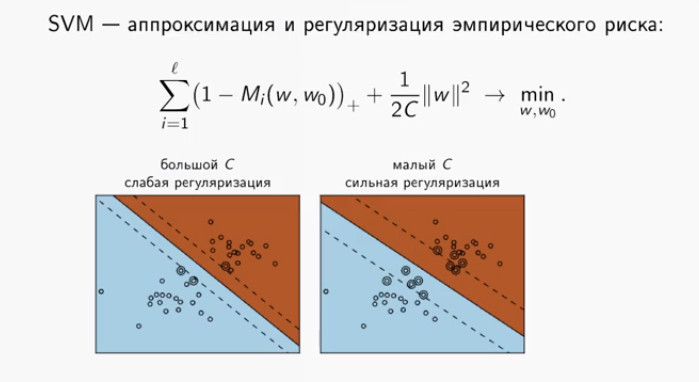

In [56]:
%%time

# Полиномиальное ядро с С=0.0000001

clf = SVC(kernel='poly', C=0.0000001)

clf.fit(X_train_word_average, train_data.topic)
prediction = clf.predict(X_test_word_average)
sklearn.metrics.f1_score(test_data.topic, prediction,average ='micro')

0.21425564753753332

In [57]:
%%time

# Полиномиальное ядро с С=1000000

clf = SVC(kernel='poly', C=1000000)
clf.fit(X_train_word_average, train_data.topic)
prediction = clf.predict(X_test_word_average)
sklearn.metrics.f1_score(test_data.topic, prediction,average ='micro')

Wall time: 27min 35s


0.7884102708011788

#### 2.2.1 Выбор оптимальных параметров

Т.к. Для поиска близости векторов наилучшим образом подойдёт "косиново расстояние" 

In [135]:
from sklearn.svm import SVC 
import sklearn.metrics 

In [136]:
clf = SVC(kernel='poly')

Т.к. Найдём оптимальное число ближайших соседей для выборки наших данных с помощью GridSearchCV()

In [137]:
from sklearn.model_selection import GridSearchCV

In [138]:
# Найдём наилучшее значение Ф-меры модели, при различных C = [1, 5, 10, 15, 20, 100, 1000, 10000]
scv_params = {'C': [1, 5, 10, 15, 20, 100, 1000, 10000]}

In [139]:
%%time
scv_grid = GridSearchCV(clf, scv_params, scoring='f1_micro', n_jobs=-1)

Wall time: 17.2 ms


In [140]:
%%time
scv_grid.fit(X_train_word_average, train_data.topic)

Wall time: 5h 5min 13s


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='poly', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 5, 10, 15, 20, 100, 1000, 10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_micro', verbose=0)

In [141]:
# Вывод наилучшего значения Ф-меры и значения числа соседё для данной медели
scv_grid.best_score_, scv_grid.best_params_

(0.8193298241604247, {'C': 5})

In [142]:
# Построение сетки значений Ф-меры для различного числа ближайших соседей 
means = scv_grid.cv_results_['mean_test_score']
for mean, params in zip(means, scv_grid.cv_results_['params']):
    print("%0.4f for %r" % (mean, params))

0.8108 for {'C': 1}
0.8193 for {'C': 5}
0.8162 for {'C': 10}
0.8122 for {'C': 15}
0.8097 for {'C': 20}
0.8018 for {'C': 100}
0.8019 for {'C': 1000}
0.8019 for {'C': 10000}


###### Вывод:

Наибольшее значение Ф-мера принимает при значении константы С от 1 до 10 

In [173]:
# Найдём наилучшее значение Ф-меры модели, при различных C = [3, 4, 5, 6, 7, 8, 9]
scv_params = {'C': [3, 4, 5, 6, 7, 8, 9]}

In [174]:
%%time
scv_grid = GridSearchCV(clf, scv_params, scoring='f1_micro', n_jobs=-1)

Wall time: 0 ns


In [175]:
%%time
scv_grid.fit(X_train_word_average, train_data.topic)

Wall time: 3h 29min 16s


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='poly', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [3, 4, 5, 6, 7, 8, 9]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='f1_micro',
             verbose=0)

In [176]:
# Вывод наилучшего значения Ф-меры и значения числа соседё для данной медели
scv_grid.best_score_, scv_grid.best_params_

(0.8193298241604247, {'C': 5})

In [177]:
# Построение сетки значений Ф-меры для различного числа ближайших соседей 
means = scv_grid.cv_results_['mean_test_score']
for mean, params in zip(means, scv_grid.cv_results_['params']):
    print("%0.4f for %r" % (mean, params))

0.8181 for {'C': 3}
0.8188 for {'C': 4}
0.8193 for {'C': 5}
0.8192 for {'C': 6}
0.8185 for {'C': 7}
0.8175 for {'C': 8}
0.8170 for {'C': 9}


###### Вывод:

Наибольшее значение Ф-мера принимает при значении константы С = 5

#### 2.2.2 Бутстрэп

###### Для повышения производительности метода SVM и повышения точности попробуем использовать "Бэккинг"

Bagging (от Bootstrap aggregation) — это один из первых и самых простых видов ансамблей. 
Он был придуман Ле́о Бре́йманом в 1994 году. Бэггинг основан на статистическом методе бутстрэпа, который позволяет оценивать многие статистики сложных распределений.


Метод бутстрэпа заключается в следующем. Пусть имеется выборка X размера N. Равномерно возьмем из выборки N объектов с возвращением. Это означает, что мы будем N раз выбирать произвольный объект выборки (считаем, что каждый объект «достается» с одинаковой вероятностью 1/N), причем каждый раз мы выбираем из всех исходных N объектов. 

Можно представить себе мешок, из которого достают шарики: выбранный на каком-то шаге шарик возвращается обратно в мешок, и следующий выбор опять делается равновероятно из того же числа шариков. Отметим, что из-за возвращения среди них окажутся повторы. Обозначим новую выборку через X1. Повторяя процедуру M раз, сгенерируем M подвыборок X1,…,XM. Теперь мы имеем достаточно большое число выборок и можем оценивать различные статистики исходного распределения.

In [22]:
from sklearn.ensemble import BaggingClassifier

In [20]:
%%time

# Полиномиальное ядро с С=5

clf = SVC(kernel='poly', C=5)
clf.fit(X_train_word_average, train_data.topic)
prediction = clf.predict(X_test_word_average)
sklearn.metrics.f1_score(test_data.topic, prediction,average ='micro')

Wall time: 12min 30s


0.8090360600533184

In [23]:
%%time
# Бэккинг 

# Полиномиальное ядро с С=5

clf = BaggingClassifier(SVC(kernel='poly', C=5))
clf.fit(X_train_word_average, train_data.topic)
prediction = clf.predict(X_test_word_average)
sklearn.metrics.f1_score(test_data.topic, prediction,average ='micro')

Wall time: 59min 19s


0.8081941911042515

##### Вывод:

Для наших данных "Бэггинг" только ужудшает качество модели

#### Для всего датасета df

In [27]:
#Разделим нашу таблицу на обучение и тест 
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)

In [28]:
%%time
X_train_word_average = word_averaging_list(wv,train_data.text)
X_test_word_average = word_averaging_list(wv,test_data.text)

2020-11-27 22:01:39,564 : WARNING : cannot compute similarity with no input ['.redirectto_PROPN']
2020-11-27 22:01:40,396 : WARNING : cannot compute similarity with no input ['жозефина-шарлотт_NOUN']
2020-11-27 22:01:40,472 : WARNING : cannot compute similarity with no input ['.redirectto_PROPN']
2020-11-27 22:01:43,069 : WARNING : cannot compute similarity with no input ['вттво_ADJ', '-омск_PROPN', 'xxxx_NUM']
2020-11-27 22:01:45,769 : WARNING : cannot compute similarity with no input ['каден_ADJ']
2020-11-27 22:01:50,029 : WARNING : cannot compute similarity with no input ['.redirectto_PROPN']
2020-11-27 22:01:50,339 : WARNING : cannot compute similarity with no input ['тунгуска-м1_NUM']
2020-11-27 22:01:54,421 : WARNING : cannot compute similarity with no input ['scotsman.com_NOUN']
2020-11-27 22:02:00,085 : WARNING : cannot compute similarity with no input ['кабар_NOUN']
2020-11-27 22:02:07,594 : WARNING : cannot compute similarity with no input ['хорайзон_PART']
2020-11-27 22:02:1

2020-11-27 22:06:07,201 : WARNING : cannot compute similarity with no input ['news24.com_X']
2020-11-27 22:06:09,314 : WARNING : cannot compute similarity with no input ['naturwissenschaften_PROPN']
2020-11-27 22:06:18,743 : WARNING : cannot compute similarity with no input ['erna_PROPN', 'retk_PROPN', 'xxxx_NUM']
2020-11-27 22:06:22,556 : WARNING : cannot compute similarity with no input ['venezuelanalysis.com_X']
2020-11-27 22:06:23,102 : WARNING : cannot compute similarity with no input ['.redirectto_PROPN']
2020-11-27 22:06:23,986 : WARNING : cannot compute similarity with no input ['drudgereport_PROPN']
2020-11-27 22:06:26,757 : WARNING : cannot compute similarity with no input ['.redirectto_PROPN']
2020-11-27 22:06:27,976 : WARNING : cannot compute similarity with no input ['myxococcus_PROPN', 'xanthus_X']
2020-11-27 22:06:30,031 : WARNING : cannot compute similarity with no input ['thechamplainchannel.com_PROPN']
2020-11-27 22:06:31,507 : WARNING : cannot compute similarity with

CPU times: user 5min 41s, sys: 2.3 s, total: 5min 43s
Wall time: 5min 44s


In [29]:
%%time

# Полиномиальное ядро с С=5

clf = SVC(kernel='poly', C=5)
clf.fit(X_train_word_average, train_data.topic)
prediction = clf.predict(X_test_word_average)
sklearn.metrics.f1_score(test_data.topic, prediction,average ='micro')

CPU times: user 1d 2h 6min 14s, sys: 1min 43s, total: 1d 2h 7min 58s
Wall time: 1d 2h 8min 19s


0.8490023293014902